In [1]:
from pybuc import buc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime


# Convenience function for computing root mean squared error
def rmse(actual, prediction):
    act, pred = actual.flatten(), prediction.flatten()
    return np.sqrt(np.mean((act - pred) ** 2))


# Import data
def parser(x):
 return datetime.strptime(x, '%Y-%m-%d')
 
series = pd.read_csv('data/visitors.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)
series.index = series.index.to_period('W')
hold_out_size = 52
series = series.astype(float)

# Create train and test sets
y_train = series.iloc[:-hold_out_size]
y_test = series.iloc[-hold_out_size:]

/tmp/ipykernel_24876/4293114978.py:20: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  series = pd.read_csv('data/visitors.csv', header=0, parse_dates=[0], index_col=0, date_parser=parser)


Number of posterior samples (after burn)  :  490
Posterior.Mean[Irregular.Var]  :  904.8405224849273
Posterior.StdDev[Irregular.Var]  :  314.49524155662476
Posterior.CredInt.LB[Irregular.Var]  :  462.5427576072566
Posterior.CredInt.UB[Irregular.Var]  :  1662.0467385249544
Posterior.Mean[Level.Var]  :  86340.75231218974
Posterior.StdDev[Level.Var]  :  103503.1954767108
Posterior.CredInt.LB[Level.Var]  :  480.253458736221
Posterior.CredInt.UB[Level.Var]  :  291415.1415862781
Posterior.Mean[Trend.Var]  :  48.598658914292265
Posterior.StdDev[Trend.Var]  :  42.54930536711145
Posterior.CredInt.LB[Trend.Var]  :  6.500315913713973
Posterior.CredInt.UB[Trend.Var]  :  170.7065517662738
Posterior.Mean[Trig-Seasonal.52.26.Var]  :  7394.2365122496785
Posterior.StdDev[Trig-Seasonal.52.26.Var]  :  11089.828142021386
Posterior.CredInt.LB[Trig-Seasonal.52.26.Var]  :  1021.7241050217162
Posterior.CredInt.UB[Trig-Seasonal.52.26.Var]  :  44468.29656181483


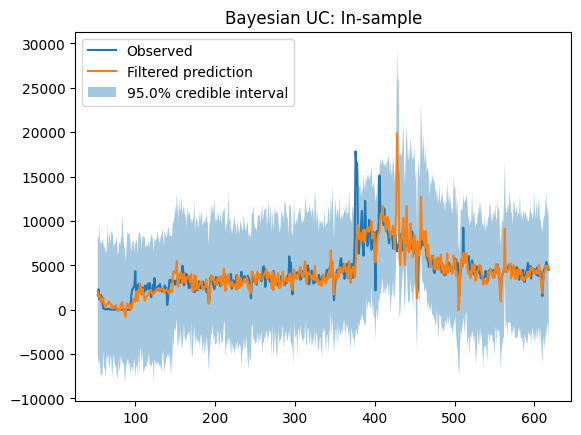

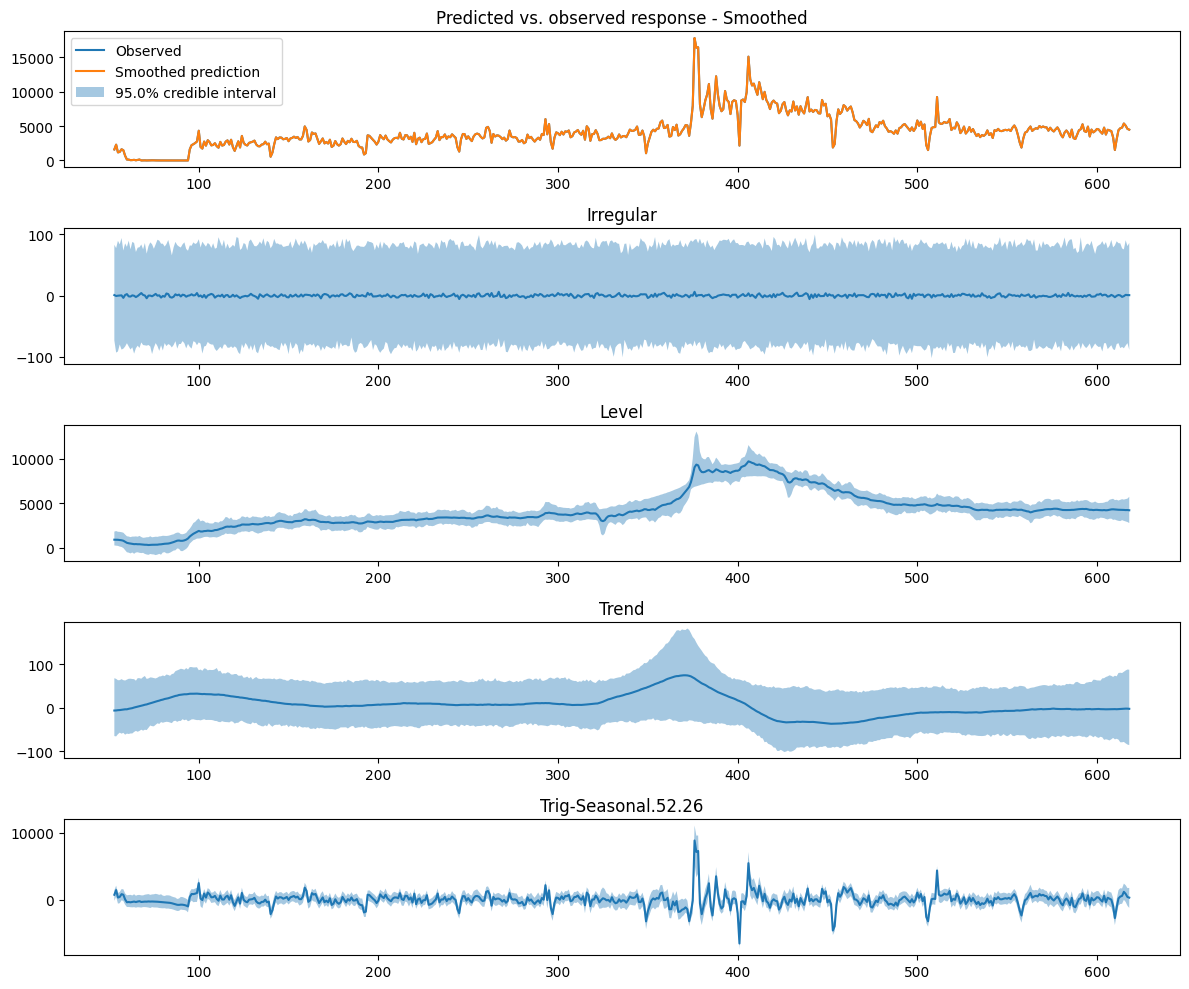

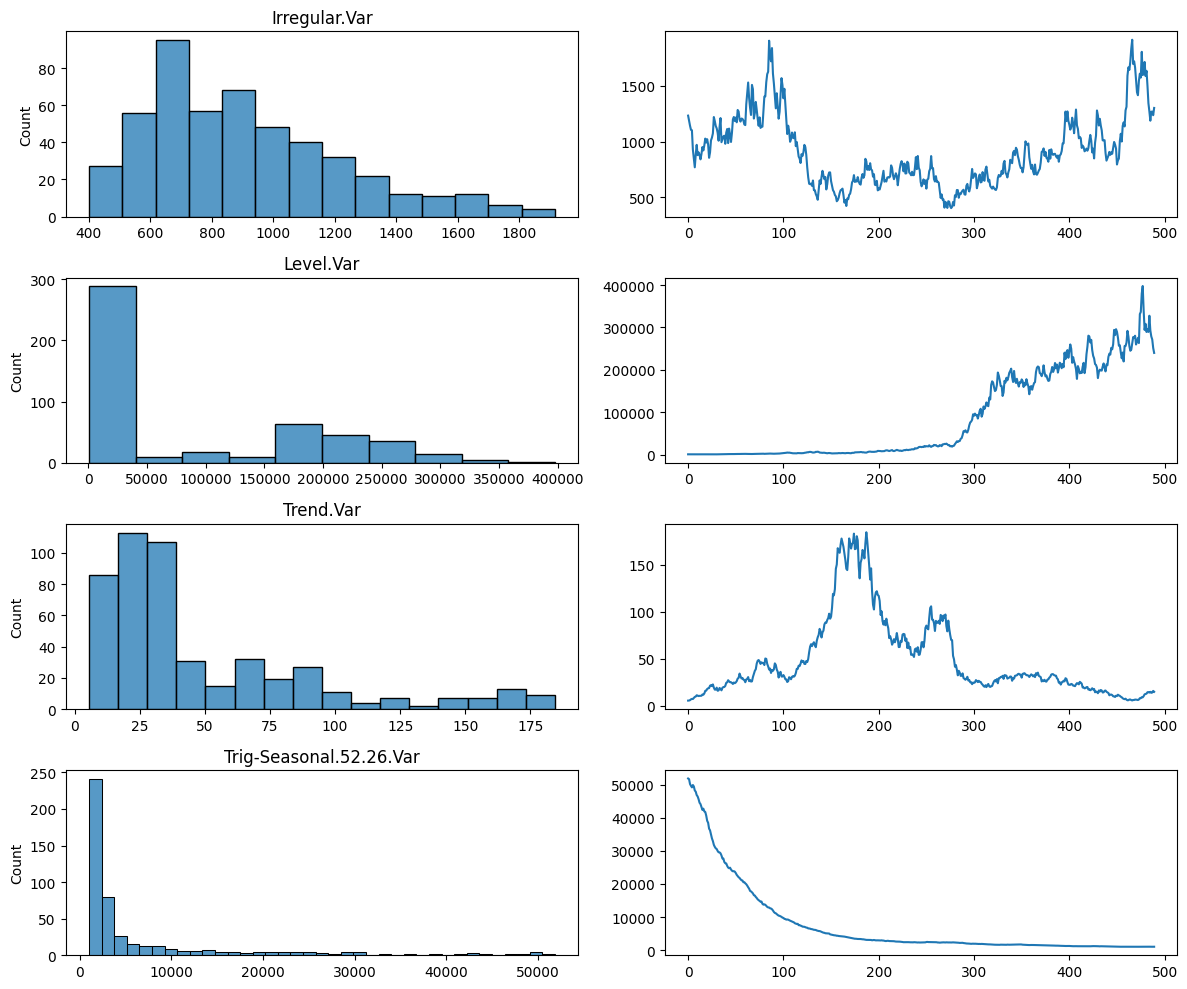

In [2]:
bayes_uc = buc.BayesianUnobservedComponents(response=y_train,
                                            level=True, stochastic_level=True,
                                            trend=True, stochastic_trend=True,
                                            trig_seasonal=((52, 0),), stochastic_trig_seasonal=(True,),
                                            seed=123)
post = bayes_uc.sample(500)
mcmc_burn = 10

# Print summary of estimated parameters
for key, value in bayes_uc.summary(burn=mcmc_burn).items():
    print(key, ' : ', value)

# Plot in-sample fit against actuals
bayes_uc.plot_post_pred_dist(burn=mcmc_burn)
plt.title('Bayesian UC: In-sample')
plt.show()

# Plot time series components
bayes_uc.plot_components(burn=mcmc_burn, smoothed=True)
plt.show()

# Plot trace of posterior
bayes_uc.plot_trace(burn=mcmc_burn)
plt.show()

# Get and plot forecast
forecast, _ = bayes_uc.forecast(hold_out_size, mcmc_burn)
forecast_mean = np.mean(forecast, axis=0)
forecast_l95 = np.quantile(forecast, 0.025, axis=0).flatten()
forecast_u95 = np.quantile(forecast, 0.975, axis=0).flatten()

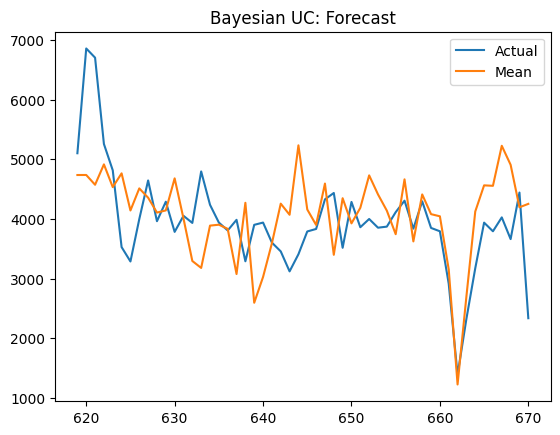

BAYES-UC RMSE: 849.8213340238871


In [3]:
pd.plotting.register_matplotlib_converters()
plt.plot(bayes_uc.future_time_index, y_test)
plt.plot(bayes_uc.future_time_index, forecast_mean)
# plt.fill_between(bayes_uc.future_time_index, forecast_l95, forecast_u95, alpha=0.2)
plt.title('Bayesian UC: Forecast')
plt.legend(['Actual', 'Mean', '95% Prediction Interval'])
plt.show()

# Print RMSE
print(f"BAYES-UC RMSE: {rmse(y_test.to_numpy(), forecast_mean)}")